# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

597

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Config Information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

In [5]:
# Decalre list values 
cities_list = []
lat = []
lon = []
temp = []
humidity = []
clouds = []
wind = []
country = []
date = []
# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
# Print statement
print('*'*20)
print('Data Processing')
print('*'*20)
# Counter Variable
i = 1
# Loop
for city in cities:
    try: 
        response = requests.get(query_url + city).json()
        # Pull data into list
        cities_list.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        clouds.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        print(f'Processing record {i} | {city}')
        i +=1
    except KeyError:
        print(f'City {i} not found. Skipping...')
print('*'*20)
print('Done')
print('*'*20)

********************
Data Processing
********************
Processing record 1 | oktyabrskiy
Processing record 2 | bubaque
Processing record 3 | avarua
Processing record 4 | hermanus
Processing record 5 | santa fe
Processing record 6 | port alfred
Processing record 7 | nago
Processing record 8 | pevek
Processing record 9 | vardo
Processing record 10 | vaini
Processing record 11 | lavrentiya
Processing record 12 | stepnyak
Processing record 13 | sitka
Processing record 14 | chokurdakh
Processing record 15 | punta arenas
Processing record 16 | singaraja
City 17 not found. Skipping...
Processing record 17 | karad
Processing record 18 | hobart
Processing record 19 | meulaboh
Processing record 20 | aden
Processing record 21 | chernyshevskiy
Processing record 22 | kapaa
Processing record 23 | rikitea
Processing record 24 | praia
Processing record 25 | mataura
City 26 not found. Skipping...
Processing record 26 | saurimo
Processing record 27 | san quintin
Processing record 28 | clyde river
Pro

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [6]:
# Create Data Dictonary
weather_data = {
    'City': cities_list,
    'Latitude': lat,
    'Longitude': lon,
    'Max Temperature': temp, 
    'Humidity': humidity,
    'Cloudiness': clouds,
    'Wind Speed': wind,
    'Country': country,
    'Date': pd.to_datetime(date, unit="s")
}
weather_df = pd.DataFrame(weather_data)
# Exporting the data to a CSV file.
weather_df.to_csv(output_data_file)
# View head to check data
weather_df.head()

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,Oktyabr'skiy,54.4815,53.4710,50.07,64,100,15.77,RU,2021-09-24 05:29:17
1,Bubaque,11.2833,-15.8333,80.87,77,100,4.14,GW,2021-09-24 05:29:17
2,Avarua,-21.2078,-159.7750,71.65,68,75,4.61,CK,2021-09-24 05:29:18
3,Hermanus,-34.4187,19.2345,55.90,87,46,7.27,ZA,2021-09-24 05:29:18
4,Santa Fe,-31.6333,-60.7000,58.01,86,0,1.99,AR,2021-09-24 05:29:13


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
#  Get the indices of cities that have humidity over 100%.
print(weather_df[weather_df['Humidity']>100].index.values)
weather_df.describe()

[]


,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,20.287385,12.446790,65.298278,70.686813,58.362637,7.713040
std,32.565920,89.716185,16.159347,21.908460,37.395928,5.630677
min,-54.800000,-175.200000,17.100000,5.000000,0.000000,0.000000
25%,-5.177450,-68.460875,52.985000,60.250000,20.000000,3.447500
50%,22.784600,15.399750,68.395000,75.000000,72.000000,6.770000
75%,46.664600,91.308525,78.270000,87.750000,94.000000,10.885000
max,78.218600,178.416700,96.690000,100.000000,100.000000,33.290000


In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

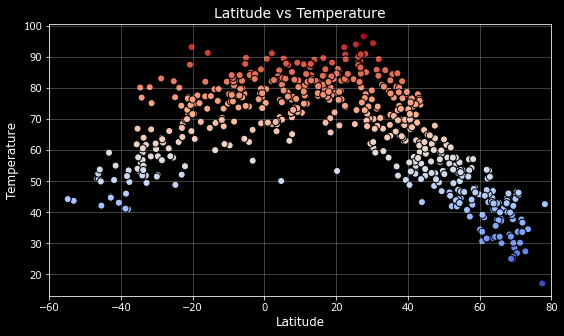

In [9]:
# Set up vars
lat = weather_df['Latitude']
temp = weather_df['Max Temperature']
# Figure size
plt.figure(figsize=(9,5))
# Plot 
plt.scatter(lat, temp, cmap='coolwarm', c = temp, edgecolor= 'black', marker='o', s=50)
# Label Plot
plt.title('Latitude vs Temperature', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Analysis 1 ^
---
This 'Latitude vs Temperature' plot shows that the temperature raises (visualized by the red plot points) the closet your point from Latitude equaling 0 degrees is; aka closer to the equator point.

## Latitude vs. Humidity Plot

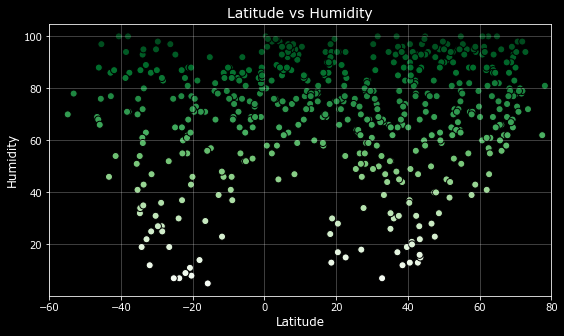

In [10]:
# Set up vars
lat = weather_df['Latitude']
humidity = weather_df['Humidity']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, humidity, c=humidity, cmap='Greens', edgecolor='black', s=50)
# Label
plt.title('Latitude vs Humidity', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()


## Analysis 2 ^
---
This 'Latitude vs Humidity' plot has a wide variety of data points spread throughout the graph. As spread out as the graph points seem to be the closer to the equator you are the less likely you are to experince humidity levels

## Latitude vs. Cloudiness Plot

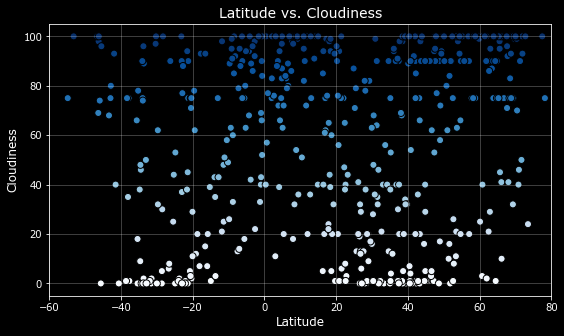

In [11]:
# Set up vars
lat = weather_df['Latitude']
cloud = weather_df['Cloudiness']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, cloud, c=cloud, edgecolors='black', cmap='Blues', s =50)
# Label
plt.title('Latitude vs. Cloudiness', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Cloudiness', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Analysis 3 ^
---
This 'Latitude vs. Cloudiness Plot' shows a strong spread across the different plot points; however, the majority of data points are substantially more dense towards 0% Cloudiness or 100% Cloudiness level

## Latitude vs. Wind Speed Plot

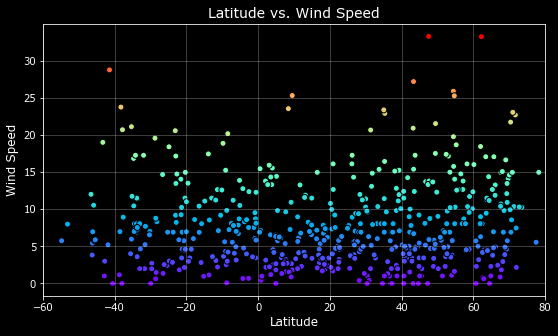

In [14]:
# Set up vars
lat = weather_df['Latitude']
wind = weather_df['Wind Speed']
# Figure size 
plt.figure(figsize=(9,5))
# Plot 
plt.scatter(lat, wind, c=wind, cmap='rainbow', edgecolors='black')
# Label
plt.title('Latitude vs. Wind Speed', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Wind Speed', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Analysis 4 ^
---
This 'Latitude vs. Wind Speed Plot' aside from the small amout of plot outliers about 25 windspeed it would appear that most cities reccieved a windspeed lower than 10mph

## Linear Regression

In [18]:
# Create the dataframe for hemispheres
north_df = weather_df[weather_df['Latitude'] > 0]
south_df = weather_df[weather_df['Latitude'] < 0]
# Create a function for linregress 
def linreg(x_values, y_values, title, text_coords):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    # Regress calcs
    regress_vals = x_values * slope + intercept
    line_eq = 'y =' + str(round(slope, 2)) + 'x +' + str(round(intercept , 2))
    # Plot
    plt.scatter(x_values, y_values, edgecolor='black', marker='o', alpha=0.5, color='aqua')
    plt.plot(x_values, regress_vals, color='orange')
    # Annotate line eq
    plt.annotate(line_eq, text_coords, fontsize=15)
    # Labels
    plt.xlabel('Latitude', fontsize=12)
    plt.ylabel(title, fontsize=12)
    print(f"The r-value is: {rvalue**2}")
    plt.show()

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.7041416852969249


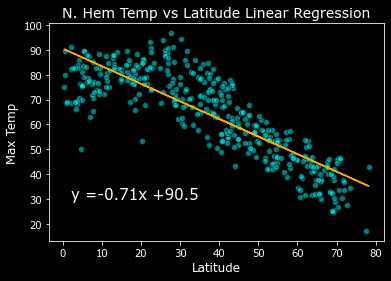

In [19]:
x_values = north_df['Latitude']
y_values = north_df['Max Temperature']
plt.title('N. Hem Temp vs Latitude Linear Regression', fontsize=14)
linreg(x_values, y_values, 'Max Temp', (2, 30))

## Observation 1 ^
---
This linear regression plot shows that temperature increases as the distance from the equator gets larger

The r-value is: 0.5406992901099555


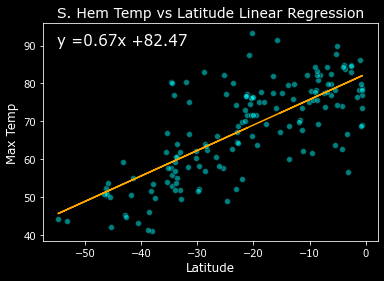

In [20]:
x_values = south_df['Latitude']
y_values = south_df['Max Temperature']
plt.title('S. Hem Temp vs Latitude Linear Regression', fontsize=14)
linreg(x_values, y_values, 'Max Temp', (-55, 90))

## Observation 2 ^
---
This linear regression plot shows that temperature decreases as the distance from the equator gets larger

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.000727274421008319


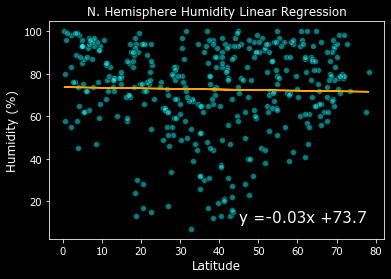

In [21]:
x_values = north_df['Latitude']
y_values = north_df['Humidity']
plt.title("N. Hemisphere Humidity Linear Regression")
linreg(x_values, y_values, 'Humidity (%)', (45,10))

## Observation 3 ^
---
There seems to be no correlation between humidity percentage and latitude.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.000727274421008319


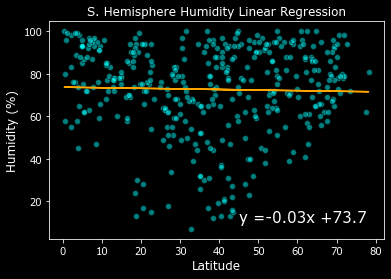

In [22]:
x_values = north_df['Latitude']
y_values = north_df['Humidity']
plt.title("S. Hemisphere Humidity Linear Regression")
linreg(x_values, y_values, 'Humidity (%)', (45,10))

## Observation 4 ^
---
There seems to be no correlation between humidity percentage and latitude.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.0069004846761565155


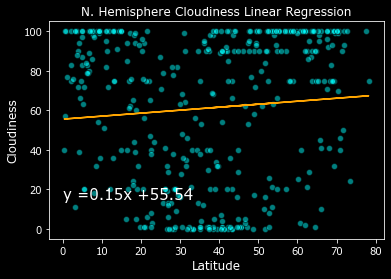

In [23]:
x_values = north_df['Latitude']
y_values = north_df['Cloudiness']
plt.title("N. Hemisphere Cloudiness Linear Regression")
linreg(x_values, y_values, 'Cloudiness', (0,15))

## Observation 5 ^
---
There seems to be no strong correlation between the Northern Hemisphere and cloud percenatage. However there is a slight raise in cloudiness the further from the hemisphere you go.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.038557877494863724


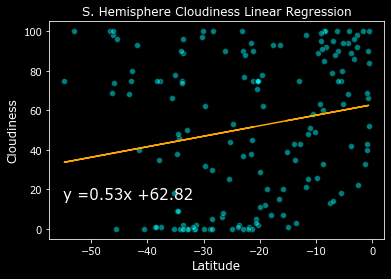

In [24]:
x_values = south_df['Latitude']
y_values = south_df['Cloudiness']
plt.title("S. Hemisphere Cloudiness Linear Regression")
linreg(x_values, y_values, 'Cloudiness', (-55,15))

## Observation 6 ^
---
There seems to be no strong correlation between between the South Hemisphere and cloud percentage. 

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.043494606144061455


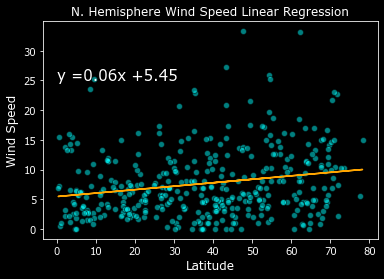

In [25]:
x_values = north_df['Latitude']
y_values = north_df['Wind Speed']
plt.title("N. Hemisphere Wind Speed Linear Regression")
linreg(x_values, y_values, 'Wind Speed', (0,25))

## Observation 7 ^
---
This plot shows that there can be a variety of windspeeds no matter the distance from the equator. Although it appears  a majority of the windspeeds tend to stay below 10mph

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.00477139095442624


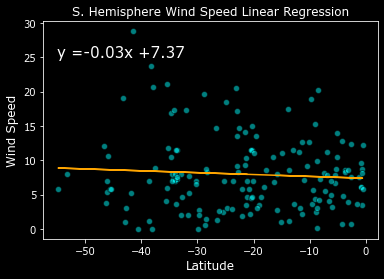

In [26]:
x_values = south_df['Latitude']
y_values = south_df['Wind Speed']
plt.title("S. Hemisphere Wind Speed Linear Regression")
linreg(x_values, y_values, 'Wind Speed', (-55,25))

## Observation 8 ^
---
There seems to be minor correlations in regards to the wind speed and latitude in this plot. 